# 基于2维卷积神经网络的故障诊断

- DE - 驱动端加速度计数据
- FE - 风扇端加速度计数据
- BA - 基座加速度计数据
- time - 时间序列数据
- RPM - 转每分钟

In [9]:
from scipy.io import loadmat
import pandas as pd
import numpy as np

In [10]:
data = pd.read_csv('../data/0HP/12k_1797_10c.csv')
data.head()

,DE_normal,DE_7_inner,DE_7_ball,DE_7_outer,DE_14_inner,DE_14_ball,DE_14_outer,DE_21_inner,DE_21_ball,DE_21_outer
0,0.053197,-0.083004,-0.002761,0.008528,-0.223836,-0.467813,0.002274,1.189431,-0.007959,0.104365
1,0.088662,-0.195734,-0.096324,0.423550,-0.209541,0.179004,-0.104948,-0.177866,0.025340,0.017462
2,0.099718,0.233419,0.113705,0.012995,0.345337,0.481295,0.082010,-0.774816,0.000162,0.116547
3,0.058621,0.103958,0.257297,-0.265175,0.158862,-0.158212,0.094027,0.501518,0.092913,0.371164
4,-0.004590,-0.181115,-0.058314,0.237155,-0.206617,-0.326819,-0.160081,0.993697,-0.007797,0.356951


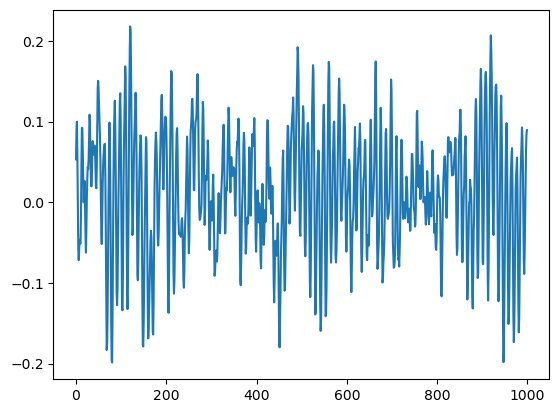

In [11]:
import matplotlib.pyplot as plt
plt.plot(data['DE_normal'][:1000])

In [12]:
SEGMENT_SIZE = 1024  # 每段样本长度
OVERLAP_RATE = 0.3   # 重叠率30%（平衡样本量与信息量）
TRAIN_RATIO = 0.7    # 训练集比例

DATA_CONFIG = [
    ('DE_normal', 0, '正常'),
    ('DE_7_inner', 1, '内圈0.007'),
    ('DE_7_ball', 2, '滚动体0.007'),
    ('DE_7_outer', 3, '外圈0.007'),
    ('DE_14_inner', 4, '内圈0.014'),
    ('DE_14_ball', 5, '滚动体0.014'),
    ('DE_14_outer', 6, '外圈0.014'),
    ('DE_21_inner', 7, '内圈0.021'),
    ('DE_21_ball', 8, '滚动体0.021'),
    ('DE_21_outer', 9, '外圈0.021'),
]

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from scipy.signal import stft
class DataPreprocessor:
    def __init__(self, data, segment_size=SEGMENT_SIZE, overlap_rate=OVERLAP_RATE, train_ratio=TRAIN_RATIO):
        self.data = data
        self.segment_size = segment_size
        self.overlap_rate = overlap_rate
        self.train_ratio = train_ratio
        self.spectrograms = []
        self.labels = []
    
    # 将一维振动信号转换为STFT时频图
    def signal2spectrogram(self, signal, fs=12000, n_fft=256, step=64):
        '''
        fs: 采样频率 12kHz
        n_fft: FFT窗口长度 → 频率维度 (n_fft//2 + 1 = 129)
        step: 步长 → 时间维度
        '''
        f, t, Zxx = stft(signal, fs=fs, nperseg=n_fft, noverlap=n_fft - step, nfft=n_fft, return_onesided=True)
        # Zxx shape: [freq_bins, time_steps, n_signals]
        magnitude = np.abs(Zxx)  # 取幅值谱
        return magnitude[:128, :].astype(np.float32)
    
    def segment_data(self):
        step_size = int(self.segment_size * (1 - self.overlap_rate))
        for column_name, label, _ in DATA_CONFIG:
            signal = self.data[column_name].values
            for start in range(0, len(signal) - self.segment_size + 1, step_size):
                segment = signal[start:start + self.segment_size]
                spectrogram = self.signal2spectrogram(segment)
                # 裁剪频率维度到128，方便后续处理
                self.spectrograms.append(spectrogram)
                self.labels.append(label)

    def get_train_test_split(self):
        spectrograms = np.array(self.spectrograms)
        labels = np.array(self.labels)
        X_train, X_test, y_train, y_test = train_test_split(
            spectrograms, labels, train_size=self.train_ratio, random_state=42, stratify=labels
        )
        return X_train, y_train, X_test, y_test
    
    def normalize_segments(self, X_train, X_test):
        # X_train: [N, F, T]
        # 在频率维度与时间维度上 flatten 后做整体标准化
        N, F, T = X_train.shape

        scaler = StandardScaler()

        # reshape to [N, F*T]
        X_train_flat = X_train.reshape(N, -1)
        X_test_flat = X_test.reshape(X_test.shape[0], -1)

        # fit only on training
        X_train_norm = scaler.fit_transform(X_train_flat)
        X_test_norm = scaler.transform(X_test_flat)

        # reshape back
        X_train = X_train_norm.reshape(N, F, T)
        X_test = X_test_norm.reshape(X_test.shape[0], F, T)
        
        return X_train, X_test
            
    def array2tensor(self, X, y, train):
        X_tensor = torch.FloatTensor(X).unsqueeze(1)  # 添加通道维度[N, 1, 128, 16]
        y_tensor = torch.LongTensor(y)
        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        if train:
            loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
        else:
            loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
        return loader

    def main(self):
        self.segment_data()
        X_train, y_train, X_test, y_test = self.get_train_test_split()
        X_train, X_test = self.normalize_segments(X_train, X_test)
        train_loader = self.array2tensor(X_train, y_train, train=True)
        test_loader = self.array2tensor(X_test, y_test, train=False)
        return train_loader, test_loader

In [14]:
import torch
import torch.nn as nn
class CNNModel(nn.Module):
    def __init__(self, num_classes, input_shape):
        super(CNNModel, self).__init__()

        # 特征提取层
        self.feature_extractor = nn.Sequential(
            # Block 1: 128x16 → 64x16
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)), # 只降频不降时

            # Block 2: 64x16 → 32x16
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)),

            # Block 3: 32x16 → 16x8
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),  # 时频均降
            
            # Block 4: 16x8 → 8x4
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # 全局池化 → [N, 256, 1, 1]
        )
        
        # 分类器
        self.classifier = nn.Sequential(
            nn.Flatten(),  # [N, 256]
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

        # 权重初始化
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # x: [batch, 1, 128, 16]
        x = self.feature_extractor(x) # [batch, 256, 1, 1]
        x = self.classifier(x)        # [batch, num_classes]
        return x

In [15]:
import time
from sklearn.metrics import confusion_matrix, classification_report

class TrainEvaluate:
    def __init__(self, model, train_loader, test_loader, criterion, optimizer, device, epochs, scheduler):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.epochs = epochs
        self.scheduler = scheduler
    
    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, targets in self.train_loader:
            inputs, targets = inputs.to(self.device), targets.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        train_loss = running_loss / len(self.train_loader)
        train_accuracy = 100. * correct / total

        return train_loss, train_accuracy
    
    def evaluate_epoch(self):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            for inputs, targets in self.test_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                all_predictions.extend(predicted.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
            
        eval_loss = running_loss / len(self.test_loader)
        eval_accuracy = 100. * correct / total

        return eval_loss, eval_accuracy, np.array(all_predictions), np.array(all_targets)
    
    def train_evaluate(self):
        best_accuracy = 0.0
        train_losses, train_accs, test_losses, test_accs = [], [], [], []
        for epoch in range(self.epochs):
            start_time = time.time()

            train_loss, train_accuracy = self.train_epoch()
            eval_loss, eval_accuracy, predictions, targets = self.evaluate_epoch()

            train_losses.append(train_loss)
            train_accs.append(train_accuracy)
            test_losses.append(eval_loss)
            test_accs.append(eval_accuracy)

            self.scheduler.step(eval_accuracy) # 学习率调度

            if eval_accuracy > best_accuracy:
                best_accuracy = eval_accuracy
                torch.save(self.model.state_dict(), "../model/2DCNN.pth")

            elapsed = time.time() - start_time
    
            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f"Epoch [{epoch+1}/{self.epochs}] "
                f"Train Loss: {train_loss:.4f} Acc: {train_accuracy:.2f}% | "
                f"Test Loss: {eval_loss:.4f} Acc: {eval_accuracy:.2f}% | "
                f"Time: {elapsed:.2f}s")
            
        self.training_curves(train_losses, test_losses, train_accs, test_accs)
        confusion_matrix(targets, predictions)
        print(classification_report(targets, predictions, target_names=[name for _, _, name in DATA_CONFIG]))
    def training_curves(self, train_losses, test_losses, train_accs, test_accs):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        ax1.plot(train_losses, label='Train Loss')
        ax1.plot(test_losses, label='Test Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.set_title('Loss Curves')
        ax1.grid(True)
        ax2.plot(train_accs, label='Train Acc')
        ax2.plot(test_accs, label='Test Acc')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.set_title('Accuracy Curves')
        ax2.grid(True)
        plt.tight_layout()
        plt.show()

Epoch [1/100] Train Loss: 1.6507 Acc: 50.17% | Test Loss: 1.8563 Acc: 20.28% | Time: 1.75s
Epoch [10/100] Train Loss: 0.0247 Acc: 99.91% | Test Loss: 0.0033 Acc: 100.00% | Time: 1.54s
Epoch [20/100] Train Loss: 0.0270 Acc: 99.66% | Test Loss: 0.0150 Acc: 99.60% | Time: 1.53s
Epoch [30/100] Train Loss: 0.0060 Acc: 100.00% | Test Loss: 0.0002 Acc: 100.00% | Time: 1.55s
Epoch [40/100] Train Loss: 0.0040 Acc: 100.00% | Test Loss: 0.0001 Acc: 100.00% | Time: 1.54s
Epoch [50/100] Train Loss: 0.0023 Acc: 100.00% | Test Loss: 0.0001 Acc: 100.00% | Time: 1.55s
Epoch [60/100] Train Loss: 0.0012 Acc: 100.00% | Test Loss: 0.0000 Acc: 100.00% | Time: 1.54s
Epoch [70/100] Train Loss: 0.0018 Acc: 100.00% | Test Loss: 0.0000 Acc: 100.00% | Time: 1.55s
Epoch [80/100] Train Loss: 0.0017 Acc: 100.00% | Test Loss: 0.0000 Acc: 100.00% | Time: 1.55s
Epoch [90/100] Train Loss: 0.0018 Acc: 100.00% | Test Loss: 0.0001 Acc: 100.00% | Time: 1.54s
Epoch [100/100] Train Loss: 0.0014 Acc: 100.00% | Test Loss: 0.000

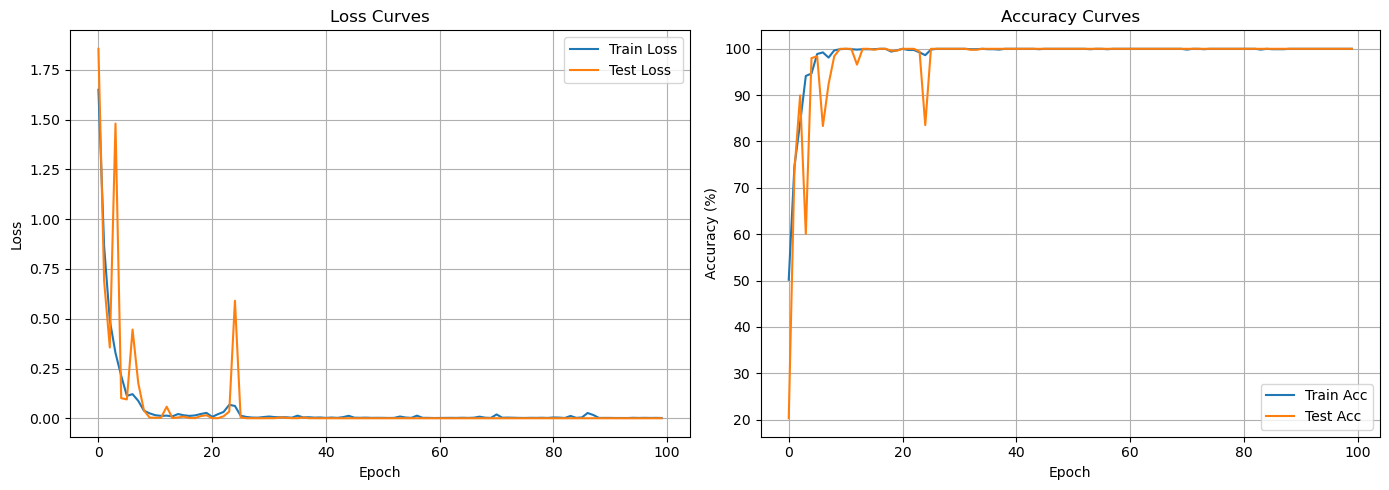

              precision    recall  f1-score   support

          正常       1.00      1.00      1.00        50
     内圈0.007       1.00      1.00      1.00        49
    滚动体0.007       1.00      1.00      1.00        50
     外圈0.007       1.00      1.00      1.00        50
     内圈0.014       1.00      1.00      1.00        50
    滚动体0.014       1.00      1.00      1.00        50
     外圈0.014       1.00      1.00      1.00        50
     内圈0.021       1.00      1.00      1.00        50
    滚动体0.021       1.00      1.00      1.00        49
     外圈0.021       1.00      1.00      1.00        50

    accuracy                           1.00       498
   macro avg       1.00      1.00      1.00       498
weighted avg       1.00      1.00      1.00       498



In [16]:
from torch import optim
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNNModel(num_classes=10, input_shape=(1, 128, 16)).to(device)
    epochs = 100
    preprocessor = DataPreprocessor(data)
    train_loader, test_loader = preprocessor.main()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10)
    train_evaluater = TrainEvaluate(model, train_loader, test_loader, criterion, optimizer, device, epochs, scheduler)
    train_evaluater.train_evaluate()

if __name__ == "__main__":
    main()